# import numpy as np
import emcee
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time 
from scipy.stats import norm
from scipy.stats import anderson_ksamp, ks_2samp, shapiro

In [2]:
np.random.seed(0)

file_path = "../csvs/random/random_features/"
planet_systems = np.loadtxt(file_path+"Order.txt", dtype = str)

def lnprob(p, vec):
    diff = vec-p[0]
    N = len(vec)
    if p[1] <=0:
        return -np.inf#0
    try:
        probs = -0.5 * N * np.log(2. * np.pi) - N/2. * np.log(np.abs(p[1])**2) - 0.5 \
                                    * np.sum(( (vec - p[0]) / p[1] ) ** 2)
    except:
        probs = 0.00
    return probs
       
def log_prob_normed(mu, sigma, info):
    prob = -np.log(2*np.pi)/2. - np.log(sigma**2.)/2.-(1./(sigma**2.)/2./info.shape[0])*np.nansum((info-mu)**2.)
    return prob
                                    
print(planet_systems.shape)

(266,)


In [3]:
nwalkers = 20
ndim = 2
iterations = 1000

sample_size = nwalkers*iterations*planet_systems.shape[0]
all_walker_samples=np.zeros((int(sample_size), 4)) 

values = np.zeros((planet_systems.shape[0], 7), dtype=str)
covariences = np.zeros((planet_systems.shape[0], ndim, ndim))

Even with the random seed set, it'll produce values ever so slightly different, but the overall result will still hold

In [11]:
info = pd.DataFrame(values, columns=["ID", "Probability", "Mean", "Sigma", "Mean_Error", "Sigma_Error", "Determinant"])
info.head()

for jj, planet_sys in enumerate(planet_systems):

    np.random.seed(jj)
    data =pd.read_csv("../../Long300/"+planet_sys, index_col = 0)
    del data["Unnamed: 0.1"]
    del data["runstring"]
    data = data[data["t"]<1e8]
    data = np.log10(data["t"].values)
    sys_name = planet_sys.split("_")[1]
    print (sys_name)

    p0 = [np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data], a=5)
    
    # Run 200 steps as a burn-in.
    pos, prob, state = sampler.run_mcmc(p0, 200)

    sampler.reset()
    
    print ("Running MCMC ...")
    start = time.time()
    pos, prob, state = sampler.run_mcmc(pos, iterations, rstate0=jj)
    end = time.time()
    print ("Done at ...", (end - start), "seconds." )

    

    #Determine the best mean and sigma
    maxprob_indice = np.argmax(prob)
    mean_fit, sigma_fit = pos[maxprob_indice]
    sigma_fit = np.abs(sigma_fit)
    #print "Estimated parameters: mean, sigma = %f, %f" % (mean_fit, sigma_fit)
    mean_samples = sampler.flatchain[:,0]
    sigma_samples = sampler.flatchain[:,1]
    mean_std = mean_samples.std()
    sigma_std = np.std(np.abs(sigma_samples) )
    covarience = np.cov([mean_samples, sigma_samples])
    print(covarience)
    determinant = np.linalg.det(covarience)
    print(determinant)
    covariences[jj, :, :] = covarience
    
    probability = -np.log(2*np.pi)/2. - np.log(sigma_fit**2.)/2.-(1./(sigma_fit**2.)/2./info.shape[0])*np.nansum((data-mean_fit)**2.)
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
       
    #SAVE INFO OF INTEREST
    if np.exp(probability)>1:
        info.loc[jj] = [sys_name]+[np.inf]+[mean_fit, sigma_fit] + [np.inf]*3

    else:
        info.loc[jj] = [sys_name, np.exp(probability), mean_fit, sigma_fit, mean_std, sigma_std, determinant]
    print (sys_name , probability, np.exp(probability),"\n")
    
    all_walker_samples[(jj)*int(iterations*nwalkers):(jj+1)*int(iterations*nwalkers), :2] = samples[:,:]
    all_walker_samples[(jj)*int(iterations*nwalkers):(jj+1)*int(iterations*nwalkers):,2] = sys_name
    all_walker_samples[(jj)*int(iterations*nwalkers):(jj+1)*int(iterations*nwalkers):,3] = jj

    #break

1007
Running MCMC ...
Done at ... 0.7950873374938965 seconds.
[[ 2.17219066e-04 -1.63876914e-06]
 [-1.63876914e-06  1.11573259e-04]]
2.423315353063089e-08
1007 -2.015932530336504 0.13319613599588728 

1021
Running MCMC ...
Done at ... 0.8015003204345703 seconds.
[[ 1.05834190e-04 -7.12052679e-07]
 [-7.12052679e-07  5.49171301e-05]]
5.811602938930458e-09
1021 -1.707810720442138 0.1812621921559921 

1025
Running MCMC ...
Done at ... 0.905705451965332 seconds.
[[1.52724038e-04 1.77280501e-06]
 [1.77280501e-06 7.66686866e-05]]
1.17060086062295e-08
1025 -1.8728352441120597 0.1536873024953472 

1041
Running MCMC ...
Done at ... 0.7739427089691162 seconds.
[[ 2.34849791e-04 -2.02173389e-06]
 [-2.02173389e-06  1.24332338e-04]]
2.919533613454927e-08
1041 -2.058881391058004 0.12759662081566103 

10518
Running MCMC ...
Done at ... 0.7512707710266113 seconds.
[[ 1.77568592e-04 -3.53718297e-06]
 [-3.53718297e-06  9.23244494e-05]]
1.6381410779438786e-08
10518 -1.9374986223933064 0.14406385756465107 

/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: overflow encountered in double_scalars


Done at ... 0.48238182067871094 seconds.
[[inf nan]
 [nan inf]]
nan
99 -2.568473412161192 0.07665247288410357 



/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/numpy/linalg/linalg.py:1874: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [14]:
info.head()

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
0,1007,0.133196,5.58763,0.464593,0.014738,0.0105626,2.42332e-08
1,1021,0.181262,6.004,0.327314,0.0102873,0.00741042,5.8116e-09
2,1025,0.153687,5.79442,0.385985,0.0123578,0.00875585,1.1706e-08
3,1041,0.127597,5.73023,0.494415,0.0153244,0.0111502,2.91953e-08
4,10518,0.144064,6.46585,0.431597,0.0133252,0.00960832,1.63814e-08


In [15]:
#save data
info.to_csv("../csvs/random/Gaussian_Fits_{0}.csv".format(info.shape[0]))

In [4]:
info = pd.read_csv("../csvs/random/Gaussian_Fits_266.csv")

short_feats = pd.read_csv("../csvs/random/deltatimes.csv", index_col =0 )
subsystem = info["ID"].values.astype(int)
sub_short = short_feats.loc[subsystem]
print(sub_short.shape)

filtered = sub_short[ (sub_short["t"]>1e4) & (sub_short["t"]<1e7) &
                    (sub_short["t_shadow"]>1e4 ) & (sub_short["t_shadow"]<1e7) ] 

print(filtered.shape)
filtered_inds = filtered.index
valid = info.loc[info["ID"].isin(filtered_inds)] 
valid.head()

(266, 3)
(248, 3)


,Unnamed: 0,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
0,0,1007,0.133196,5.587629,0.464593,0.014738,0.010563,2.423315e-08
1,1,1021,0.181262,6.003999,0.327314,0.010287,0.007410,5.811603e-09
2,2,1025,0.153687,5.794418,0.385985,0.012358,0.008756,1.170601e-08
3,3,1041,0.127597,5.730234,0.494415,0.015324,0.011150,2.919534e-08
4,4,10518,0.144064,6.465849,0.431597,0.013325,0.009608,1.638141e-08


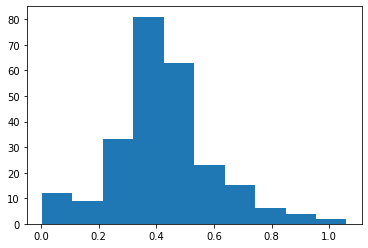

In [5]:
plt.hist(valid["Sigma"])
plt.show()

In [26]:
#do tests for only valid systems within the instability time range cuts

planet_systems = ["Sys_{0}_1e8.csv".format(x) for x in valid["ID"] ]
sig_levels_and = np.zeros(len(planet_systems))
sig_levels_kstest = np.zeros(len(planet_systems))
sig_levels_shapiro = np.zeros(len(planet_systems))

for jj, planet_sys in enumerate(planet_systems):

    np.random.seed(jj)
    data = pd.read_csv("../csvs/random/random_features/"+planet_sys, index_col = 0)
    del data["Unnamed: 0.1"]
    del data["runstring"]
    data = data[data["t"]<1e8]
    data = np.log10(data["t"].values)
    sys_name = planet_sys.split("_")[1]

    # normal we want to match
    test = np.random.normal(loc=valid.iloc[jj]["Mean"], scale=valid.iloc[jj]["Sigma"], size = data.shape[0])
    
    # anderson stats
    try:
        statistic, crit_val, sig_level =  anderson_ksamp([data, test])
    except Exception as e:
        print (e)
        statistic, crit_val, sig_level = 0,0,0
    print (sys_name)
    print ("Anderson",  statistic,  crit_val, sig_level)
    sig_levels_and[jj] = sig_level

    try:
        statistic, p_val = ks_2samp(data, test)
    except:
        statistic, p_val = 0,0
    sig_levels_kstest[jj] = p_val
    print ("KS", statistic, p_val) 
    
    #shapiro   
    try:
        statistic, p_val = shapiro(data)
    except:
        statistic, p_val = 0,0
    sig_levels_shapiro[jj] = p_val
    print ("Shapiro", statistic, p_val)
   

1007
Anderson 0.5811298539459333 [0.325 1.226 1.961 2.718 3.752] 0.19182871121811315
KS 0.045 0.2575111755149523
SH 0.9768258333206177 1.5473778508523495e-11
1021
Anderson 0.7300121547435395 [0.325 1.226 1.961 2.718 3.752] 0.16511909144452788
KS 0.046999999999999986 0.21398843459234218
SH 0.9904751181602478 4.495232587942155e-06
1025
Anderson 0.6447355265634338 [0.325 1.226 1.961 2.718 3.752] 0.17990156910461577
KS 0.035 0.5654378910227631
SH 0.9738745093345642 1.9765307012614697e-12
1041
Anderson 14.39617023938519 [0.325 1.226 1.961 2.718 3.752] 2.064124755889286e-05
KS 0.12060301507537685 8.813667689418526e-07
SH 0.9175072312355042 7.356836653823186e-23
10518
Anderson 7.4187497082367635 [0.325 1.226 1.961 2.718 3.752] 0.0006234312611252775
KS 0.09365558912386707 0.00029908882058131176
SH 0.9561244249343872 1.1573471732500575e-16
1052
Anderson 0.0699081125080882 [0.325 1.226 1.961 2.718 3.752] 0.3237522031822251
KS 0.03799999999999992 0.4585797916571768
SH 0.9942735433578491 0.0007361

/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


1266
Anderson 15.823732537919534 [0.325 1.226 1.961 2.718 3.752] 1.392303363911035e-05
KS 0.11699999999999999 1.946984145462294e-06
SH 0.9275112152099609 1.4526389145940254e-21
1270
Anderson 12.8975146495156 [0.325 1.226 1.961 2.718 3.752] 3.486827113510573e-05
KS 0.134 2.6029433636230157e-08
SH 0.9601483345031738 7.053209999864261e-16
1277
Anderson 43.67548662371888 [0.325 1.226 1.961 2.718 3.752] 5.835364836896951
KS 0.20500000000000002 7.00344189780048e-19
SH 0.8098023533821106 1.0146427160600397e-32
12840
Anderson 4.235737304024738 [0.325 1.226 1.961 2.718 3.752] 0.006687362880488545
KS 0.05500000000000001 0.09386953704676426
SH 0.9498855471611023 6.049536192660121e-18
1308
Anderson 16.0458452968858 [0.325 1.226 1.961 2.718 3.752] 1.3217616770367957e-05
KS 0.126 2.1326445737278948e-07
SH 0.9161872863769531 4.3700688494153056e-23
1313
Anderson 4.247927450512602 [0.325 1.226 1.961 2.718 3.752] 0.00662039396483976
KS 0.07307307307307304 0.009086312734454456
SH 0.9607555270195007 9.794

In [12]:
scores = np.vstack([ valid["ID"], sig_levels_and, sig_levels_kstest, sig_levels_shapiro])
print scores.shape
scores = pd.DataFrame(scores.T, columns=["ID", "Anderson_P", "KS_P", "ShapiroW"] )
scores.head(20)

(4, 248)


,ID,Anderson_P,KS_P,ShapiroW
0,1007.0,0.187266,2.815733e-01,1.547378e-11
1,1021.0,0.097348,1.595541e-01,4.495233e-06
2,1025.0,0.188708,5.654379e-01,1.976531e-12
3,1041.0,0.000021,8.813668e-07,7.356837e-23
4,10518.0,0.000409,1.678923e-04,1.157347e-16
5,1052.0,0.205259,3.631990e-01,7.361152e-04
6,1107.0,0.011290,7.484708e-02,3.177200e-14
7,1120.0,0.610480,6.785104e-01,1.722353e-03
8,1124.0,0.004557,2.628441e-03,2.619127e-14
9,1128.0,0.025837,3.632700e-03,1.875177e-09


In [24]:
scores.to_csv("../csvs/random/signficance_scores_new_scipy.csv", index=0)
scores.head()

,ID,Anderson_P,KS_P,ShapiroW
0,1007.0,0.187266,2.815733e-01,1.547378e-11
1,1021.0,0.097348,1.595541e-01,4.495233e-06
2,1025.0,0.188708,5.654379e-01,1.976531e-12
3,1041.0,0.000021,8.813668e-07,7.356837e-23
4,10518.0,0.000409,1.678923e-04,1.157347e-16
